## Prepare NDVI from AVHRR Data

In this notebook, daily NDVI data from the AVHRR Sensors of the NOAA platforms from 1981 - 1999 is processed. The following steps are included:
- Crop data to Germany
- Mask pixels based on quality flags
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests
- Save information on quality flags and counts of high quality pixels per year as csv datasets

In [1]:
# import libraries
import os
import pathlib
import xarray as xr
import geopandas as gpd
import odc.stac
import rasterio
import pandas as pd
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# load NDVI dataset of one day as example
ndvi_ex = xr.open_dataset("./Raw/NDVI_AVHRR/1981/AVHRR-Land_v005_AVH13C1_NOAA-07_19810625_c20170610042839.nc", 
                     decode_coords="all", 
                     decode_times=True)

In [5]:
# look at dataset
ndvi_ex

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 165, longitude: 196, ncrs: 1)
Coordinates:
  * time       (time) datetime64[ns] 1981-06-25
  * latitude   (latitude) float32 55.17 55.12 55.07 55.02 ... 47.07 47.02 46.97
  * longitude  (longitude) float32 5.425 5.475 5.525 5.575 ... 15.07 15.12 15.18
    crs        (ncrs) int16 ...
Dimensions without coordinates: ncrs
Data variables:
    NDVI       (time, latitude, longitude) float32 ...
    QA         (time, latitude, longitude) int16 ...
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] ...
Attributes: (12/49)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeLand:                29.50
    PercentValidClearDaytimeLand:           4.87
    PercentValidDaytimeLandInCloudShadow:   2.77
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00
    History:                                Translated to CF-1.0 Conventions ...

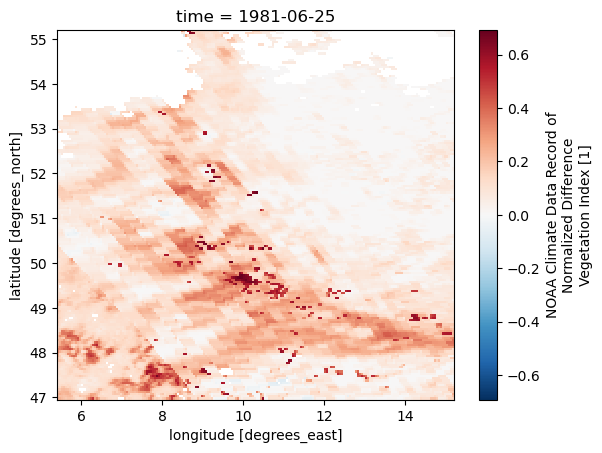

In [6]:
# plot NDVI and Quality flags to get a first impression
ndvi_ex.NDVI.plot()

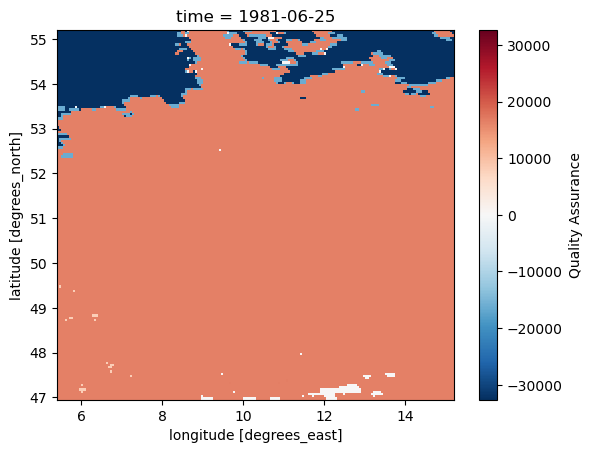

In [7]:
ndvi_ex.QA.plot()

In [8]:
# check crs
ndvi_ex.rio.crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["undefined",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [9]:
ndvi_ex.rio.write_crs(4326, inplace=True)

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 165, longitude: 196)
Coordinates:
  * time       (time) datetime64[ns] 1981-06-25
  * latitude   (latitude) float32 55.17 55.12 55.07 55.02 ... 47.07 47.02 46.97
  * longitude  (longitude) float32 5.425 5.475 5.525 5.575 ... 15.07 15.12 15.18
    crs        int32 0
Data variables:
    NDVI       (time, latitude, longitude) float32 ...
    QA         (time, latitude, longitude) int16 ...
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] ...
Attributes: (12/49)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeLand:                29.50
    PercentValidClearDaytimeLand:           4.87
    PercentValidDaytimeLandInCloudShadow:   2.77
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00
    History:                                Translated to CF-1.0 Conventions ...

In [10]:
# check crs again
ndvi_ex.rio.crs

CRS.from_epsg(4326)

In [11]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [12]:
# check if crs matches ndvi data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# create mask of research area using the dimensions of the exemplary ndvi data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=ndvi_ex.odc.geobox.shape,
                                            transform=ndvi_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [14]:
ger_mask = xr.DataArray(ger_mask, dims=("latitude", "longitude"))

In [15]:
# create loop to process all datasets
for year in range(1981, 2000):

    # open daily netCDF datasets of corresponding year
    directory = f"./Raw/NDVI_AVHRR/{year}"
    files = list(pathlib.Path(directory).glob('*.nc'))

    for f in range(len(files)):
        file = files[f]
        
        ndvi = xr.open_dataset(file, decode_coords = "all", decode_times = True)

        # define crs
        ndvi.rio.write_crs(4326, inplace = True)

        # apply mask of research area to ndvi dataset 
        ndvi_ger = ndvi.where(~ger_mask)
        
        # extract quality flag pixel values as dataframe
        df_qa_pixelvalues = ndvi_ger.QA.to_dataframe()

        # count frequency of pixel values and extract to dataframe
        df_qa_freq = df_qa_pixelvalues["QA"].value_counts().to_frame()

        # create new column with quality flag
        df_qa_freq["qa_flag"] = df_qa_freq.index

        # reset index
        df_qa_freq.reset_index(drop = True, inplace = True)

        # rename column with counts
        df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

        # convert values to integer
        df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

        # convert quality flags to binary to assess quality information stored in bits
        # define function to convert decimal numbers to signed 16bit
        def to_signed_16bit(n):
            # make sure value is an integer
            n = int(n)
            if n < 0:
            # apply 2's complement for negative numbers
                n = (1 << 16) + n
            # convert to 16-bit binary string
            return f'{n:016b}'
        
        # apply function to quality flag column 
        df_qa_freq["binary"] = df_qa_freq["qa_flag"].apply(to_signed_16bit)

        # create new columns with the different quality information stored in the bits to assess them seperately
        # source: https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/Normalized_Difference_Vegetation_Index/AVHRR/AlgorithmDescriptionAVHRR_01B-20b.pdf
        df_qa_freq['Polar'] = df_qa_freq['binary'].astype(str).str[0]
        df_qa_freq['BRDF-correction issues'] = df_qa_freq['binary'].astype(str).str[1]
        df_qa_freq['RHO3 invalid'] = df_qa_freq['binary'].astype(str).str[2]
        df_qa_freq['Channel 5 invalid'] = df_qa_freq['binary'].astype(str).str[3]
        df_qa_freq['Channel 4 invalid'] = df_qa_freq['binary'].astype(str).str[4]
        df_qa_freq['Channel 3 invalid'] = df_qa_freq['binary'].astype(str).str[5]
        df_qa_freq['Channel 2 invalid'] = df_qa_freq['binary'].astype(str).str[6]
        df_qa_freq['Channel 1 invalid'] = df_qa_freq['binary'].astype(str).str[7]
        df_qa_freq['Channels 1-5 valid'] = df_qa_freq['binary'].astype(str).str[8]
        df_qa_freq['Night'] = df_qa_freq['binary'].astype(str).str[9]
        df_qa_freq['Dense dark vegetation'] = df_qa_freq['binary'].astype(str).str[10]
        df_qa_freq['Sunglint'] = df_qa_freq['binary'].astype(str).str[11]
        df_qa_freq['Water'] = df_qa_freq['binary'].astype(str).str[12]
        df_qa_freq['Cloud Shadow'] = df_qa_freq['binary'].astype(str).str[13]
        df_qa_freq['Cloudy'] = df_qa_freq['binary'].astype(str).str[14]
        df_qa_freq['Unused'] = df_qa_freq['binary'].astype(str).str[15]
        
        # extract all quality flag values that are fit for our purpose and should be kept in the dataset
        df_qa_tokeep = df_qa_freq[(df_qa_freq['Cloudy']=="0") & 
                                (df_qa_freq['Channel 1 invalid']=="0") & 
                                (df_qa_freq["Channel 2 invalid"]=="0") &
                                (df_qa_freq["Night"]=="0") &
                                (df_qa_freq["Sunglint"]=="0")]
        
        qa_tokeep = df_qa_tokeep["qa_flag"]

        # create a mask for the ndvi datasets that only keeps pixels of good quality
        mask = ndvi_ger["QA"].isin(qa_tokeep).compute()

        # mask dataset
        ndvi_masked = ndvi_ger["NDVI"].where(mask, drop = False)

        # load forest area from ESA Landcover data for corresponding year
        # attention: forest data only available for 1992 - 2022 -> choose 1992 for ndvi data of 1981-1992

        if year <= 1992:
            forest_year = 1992
        else: forest_year = year
        
        forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                                decode_coords = "all", 
                                decode_times= True)

        # set crs for ndvi data
        ndvi_masked.rio.write_crs(4326, inplace = True)

        # rename dimensions to match forest dataset
        ndvi_masked = ndvi_masked.rename({'latitude':'lat', 'longitude':'lon'})

        # resample ndvi dataset to match resolution of forest dataset
        ndvi_match = ndvi_masked.rio.reproject_match(forest)

        # rename dimensions again - they got renamed while resampling
        ndvi_match = ndvi_match.rename({'y':'lat', 'x':'lon'})

        # mask ndvi with forest data
        # broadleaved forest:
        ndvi_BL = ndvi_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

        # needleleaved forest:
        NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
        ndvi_NL = ndvi_match.where(NL_mask, drop = False)
        
        # save as netCDF4 datasets
        date = ndvi_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
        ndvi_BL.to_netcdf(f"./NDVI/Daily/{year}/NDVI_{date}_BL.nc")
        ndvi_NL.to_netcdf(f"./NDVI/Daily/{year}/NDVI_{date}_NL.nc")

    # print status
    print(f"Files for year {year} processed.")

Files for year 1981 processed.
Files for year 1982 processed.
Files for year 1983 processed.
Files for year 1984 processed.
Files for year 1985 processed.
Files for year 1986 processed.
Files for year 1987 processed.
Files for year 1988 processed.
Files for year 1989 processed.
Files for year 1990 processed.
Files for year 1991 processed.
Files for year 1992 processed.
Files for year 1993 processed.
Files for year 1994 processed.
Files for year 1995 processed.
Files for year 1996 processed.
Files for year 1997 processed.
Files for year 1998 processed.
Files for year 1999 processed.


In [18]:
# load one processed dataset as example and plot to get an overview
ndvi_NL = xr.open_dataarray("./NDVI/Daily/1999/NDVI_1999-08-01_NL.nc", decode_coords = "all", decode_times= True)
ndvi_NL

<xarray.DataArray 'NDVI' (time: 1, lat: 2952, lon: 3510)>
[10361520 values with dtype=float32]
Coordinates:
  * lon          (lon) float64 5.451 5.454 5.457 5.46 ... 15.19 15.19 15.2 15.2
  * lat          (lat) float64 55.2 55.2 55.19 55.19 ... 47.01 47.01 47.0 47.0
  * time         (time) datetime64[ns] 1999-08-01
    crs          int32 ...
    spatial_ref  int32 ...
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    standard_name:  normalized_difference_vegetation_index
    _ChunkSizes:    [   1 1200 2400]

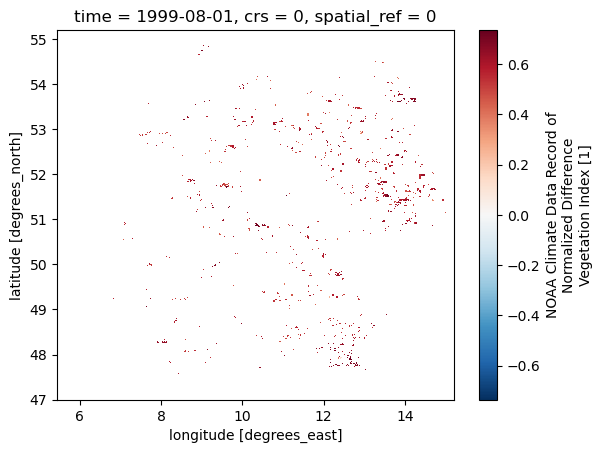

In [19]:
ndvi_NL.plot()

In [20]:
# to get more information on pixel quality:
# count quality flag frequencies and pixels of high quality per year
years = []
pixel_counts = []
high_quality_pixel_counts = []

In [ ]:
# loop over years to get pixel counts
for year in range(1981, 2000):
    
    directory = f"./Raw/NDVI_AVHRR/{year}"

    # open netCDF dataset of corresponding year with all daily datasets concatenated
    ndvi = xr.open_mfdataset(f"{directory}/*.nc", concat_dim="time", combine="nested", engine="netcdf4")

    # extract quality flag pixel values as dataframe
    df_qa_pixelvalues = ndvi.QA.to_dataframe()

    # count frequency of pixel values and extract to dataframe
    df_qa_freq = df_qa_pixelvalues["QA"].value_counts().to_frame()

    # create new column with quality flag
    df_qa_freq["qa_flag"] = df_qa_freq.index

    # reset index
    df_qa_freq.reset_index(drop = True, inplace = True)

    # rename column with counts
    df_qa_freq.rename({'count':'qa_flag_freq'},axis=1, inplace= True)

    # convert values to integer
    df_qa_freq["qa_flag"] = df_qa_freq["qa_flag"].astype("int16")

    # convert quality flags to binary to assess quality information stored in bits
    # define function to convert decimal numbers to signed 16bit
    def to_signed_16bit(n):
        # make sure value is an integer
        n = int(n)
        if n < 0:
        # apply 2's complement for negative numbers
            n = (1 << 16) + n
        # convert to 16-bit binary string
        return f'{n:016b}'
        
    # apply function to quality flag column 
    df_qa_freq["binary"] = df_qa_freq["qa_flag"].apply(to_signed_16bit)

    # create new columns with the different quality information stored in the bits to assess them seperately
    # source: https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/Normalized_Difference_Vegetation_Index/AVHRR/AlgorithmDescriptionAVHRR_01B-20b.pdf
    df_qa_freq['Polar'] = df_qa_freq['binary'].astype(str).str[0]
    df_qa_freq['BRDF-correction issues'] = df_qa_freq['binary'].astype(str).str[1]
    df_qa_freq['RHO3 invalid'] = df_qa_freq['binary'].astype(str).str[2]
    df_qa_freq['Channel 5 invalid'] = df_qa_freq['binary'].astype(str).str[3]
    df_qa_freq['Channel 4 invalid'] = df_qa_freq['binary'].astype(str).str[4]
    df_qa_freq['Channel 3 invalid'] = df_qa_freq['binary'].astype(str).str[5]
    df_qa_freq['Channel 2 invalid'] = df_qa_freq['binary'].astype(str).str[6]
    df_qa_freq['Channel 1 invalid'] = df_qa_freq['binary'].astype(str).str[7]
    df_qa_freq['Channels 1-5 valid'] = df_qa_freq['binary'].astype(str).str[8]
    df_qa_freq['Night'] = df_qa_freq['binary'].astype(str).str[9]
    df_qa_freq['Dense dark vegetation'] = df_qa_freq['binary'].astype(str).str[10]
    df_qa_freq['Sunglint'] = df_qa_freq['binary'].astype(str).str[11]
    df_qa_freq['Water'] = df_qa_freq['binary'].astype(str).str[12]
    df_qa_freq['Cloud Shadow'] = df_qa_freq['binary'].astype(str).str[13]
    df_qa_freq['Cloudy'] = df_qa_freq['binary'].astype(str).str[14]
    df_qa_freq['Unused'] = df_qa_freq['binary'].astype(str).str[15]

    # save quality flag frequencies as csv
    df_qa_freq.to_csv(f"./Tables/NDVI_Quality_Assessment/NDVI_QA_Flag_Frequency_{year}.csv")

    # extract all quality flag values that are fit for our purpose and should be kept in the dataset
    df_qa_tokeep = df_qa_freq[(df_qa_freq['Cloudy']=="0") & 
                                (df_qa_freq['Channel 1 invalid']=="0") & 
                                (df_qa_freq["Channel 2 invalid"]=="0") &
                                (df_qa_freq["Night"]=="0") &
                                (df_qa_freq["Sunglint"]=="0")]

    # append counts to lists    
    years.append(year)
    pixel_counts.append(sum(df_qa_freq.qa_flag_freq))
    high_quality_pixel_counts.append(sum(df_qa_tokeep.qa_flag_freq))

In [22]:
df_qa_pixel_counts = pd.DataFrame({"Year": years,
                                "Pixels": pixel_counts,
                                "High_Quality_Pixels": high_quality_pixel_counts})

In [23]:
df_qa_pixel_counts

,Year,Pixels,High_Quality_Pixels
0,1981,6176940,397758
1,1982,11545380,1013876
2,1983,11771760,790596
3,1984,11739420,702304
4,1985,11739420,979302
5,1986,11739420,876868
6,1987,11771760,669269
7,1988,11836440,814150
8,1989,11804100,1746436
9,1990,11771760,1563676


In [ ]:
# save pixel counts as csv
df_qa_pixel_counts.to_csv("./Tables/NDVI_Quality_Assessment/NDVI_QA_Pixel_Counts_1981-1999.csv")